# Import Library

In [776]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from desdeo_mcdm.interactive.NautilusNavigator import NautilusNavigator

In [777]:
from graph import Graph, Point
from optimization import generate_rand_points, crossover, dominates, non_dominated_sort, crowding_distance, random_connected_partitions

# Generate Graph

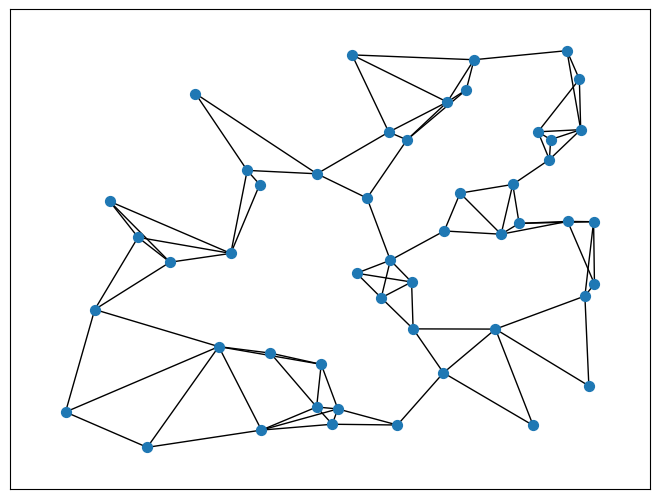

In [778]:
np.random.seed(15)

n_points = 50
n_partition = 4
interval = [-30, 30]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

weight = graph.calculate_weight(3, 4)
pos = {i: (graph.get_points()[i].get("x"), graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

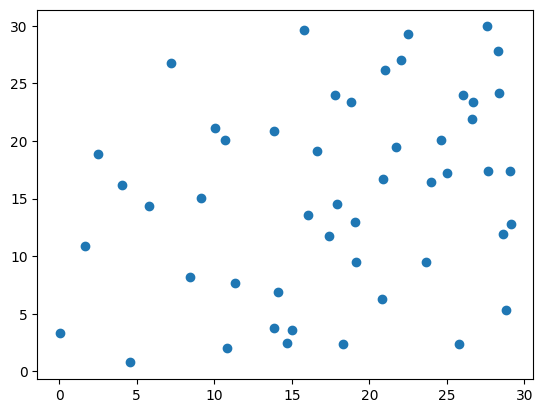

In [779]:
plt.scatter(points_x, points_y)
plt.savefig('./plot/scattered-data.png')

# To Excel

In [780]:
weight_df = pd.DataFrame(weight)
weight_df.to_csv('weight.csv')

# NSGA 2

## Objective Function

In [781]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

In [782]:
mutation_rate = 0.8
crossover_rate = 0.4
n_iteration = 500
n_population = 1000

In [783]:
populations = np.array([])

for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)

for i in tqdm(range(n_iteration)):
    populations_with_offspring = np.copy(populations)

    for i in range(n_population // 2):
        a = deepcopy(populations[np.random.randint(0, n_population)])
        b = deepcopy(populations[np.random.randint(0, n_population)])
        
        populations = np.append(new_graph, populations)
        if(np.random.rand() <= crossover_rate):
            a, b = crossover(a, b, n_partition)
        if(np.random.rand() <= mutation_rate):
            a.mutate_graph()
        if(np.random.rand() <= mutation_rate):
            b.mutate_graph()
        
        populations_with_offspring = np.append(populations_with_offspring, [a, b])

    f_list = np.array([])
    for i, population in enumerate(populations_with_offspring):
        f_list = np.append(f_list, [i, f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

    f_list = f_list.reshape(n_population * 2, 4)

    fronts = non_dominated_sort(f_list)
    fronts = fronts[:len(fronts) - 1]
    crowding_distance_list = []

    for i, front in enumerate(fronts):
        crowding_distance_list.append([])
        crowding_distance_list[i] = crowding_distance(front, f_list[:, 1:])

    new_population = np.array([])

    for i, front in enumerate(fronts):
        front_temp = sorted([[front[j], crowding_distance_list[i][j]] for j in range(len(crowding_distance_list[i]))], key=lambda x: x[1], reverse=True)
        for val in front_temp:
            if(len(new_population) < n_population):
                new_population = np.append(new_population, populations_with_offspring[val[0]])
            else: 
                break
        else:
            continue
        break

    populations = np.copy(new_population)

100%|██████████| 500/500 [3:41:23<00:00, 26.57s/it]  


In [1003]:
f_list = np.array([])

for i, population in enumerate(populations):
    f_list = np.append(f_list, [f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

f_list = f_list.reshape(n_population, 3)

px.scatter_3d(x=f_list[:, 0], y=f_list[:, 1], z=f_list[:, 2], opacity=0.5)

ValueError: cannot reshape array of size 9000 into shape (1000,3)

## Generate XLSX

In [785]:
columns = np.append(np.array(['f1', 'f2', 'f3']), ['var' for i in range(n_points)])
output = pd.DataFrame(columns=columns)

colums_point = np.append(np.array(['x', 'y']), values=[])
output_point = pd.DataFrame(columns=colums_point)

for population in populations: 
    f1, f2, f3 = f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)
    var = population.get_partition()
    data = np.append([f1, f2, f3], [val for val in var])
    output.loc[len(output)] = data

output_point[output_point.columns[0]] = populations[0].get_points_coords()[0]
output_point[output_point.columns[1]] = populations[0].get_points_coords()[1]

# output.to_excel('output_var_2.xlsx')
# output_point.to_csv('output_point.csv')

## Load CSV

In [1125]:
output_0 = pd.read_excel('output_var_0.xlsx')
output_1 = pd.read_excel('output_var_1.xlsx')
output_2 = pd.read_excel('output_var_2.xlsx')

output = pd.concat([output_0, output_1, output_2])
output = output.iloc[:, 1:].reset_index()

f1, f2, f3 = output.f1, output.f2, output.f3

In [1126]:
populations = np.array([])
for i in range(len(output)):
    new_graph = deepcopy(graph) 
    for j in range(n_points):
        if(j == 0):
            new_graph.update_partition(j, output['var'][i])
        else: 
            new_graph.update_partition(j, output[f'var.{j}'][i])
    populations = np.append(populations, new_graph)

In [1127]:
px.scatter_3d(output, x='f1', y='f2', z='f3', opacity=0.25)

# Interactive

In [1195]:
front = np.array([f1, f2, f3], dtype=object).T
nadir = np.array([np.max(f1), np.max(f2), np.max(f3)])
ideal = np.array([np.min(f1), np.min(f2), np.min(f3)])

print(f"Nadir Point: {nadir}")
print(f"Ideal Point: {ideal}")

Nadir Point: [ 89.80123534 138.          73.48069231]
Ideal Point: [22.33726026  6.         29.167319  ]


In [1196]:
method = NautilusNavigator(front, ideal, nadir)

req_first = method.start()
print(req_first.content["reachable_ub"])
print(req_first.content["reachable_lb"])

reference_point = np.array([55, 50, 60])
go_to_previous = False
stop = False
speed = 1

response = dict(reference_point=reference_point, go_to_previous=False, stop=False, speed=1, user_bounds=[None, None, None])

req_first.response = response
req_snd = method.iterate(req_first)

print(req_snd.content["reachable_ub"])
print(req_snd.content["reachable_lb"])

previous_requests = [req_first, req_snd]
req = req_snd

while method._step_number < 30:
    req.response = response
    req = method.iterate(req)

    previous_requests.append(req)

[ 89.80123534 138.          73.48069231]
[22.33726026  6.         29.167319  ]
[ 89.80123534 138.          73.48069231]
[22.33726026  6.         29.167319  ]


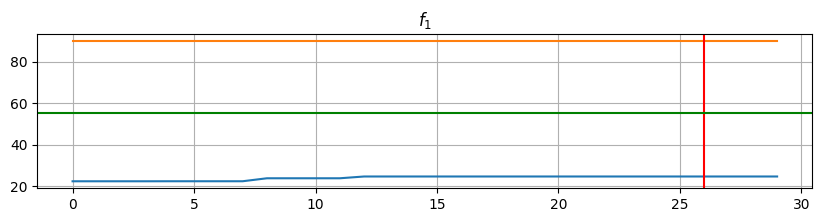

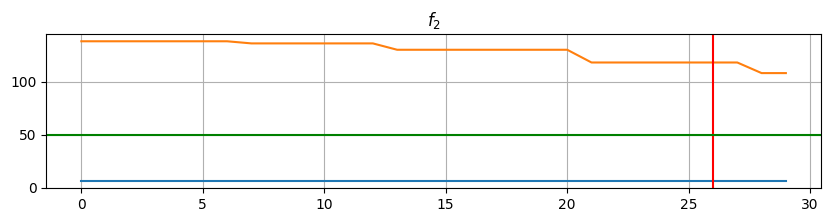

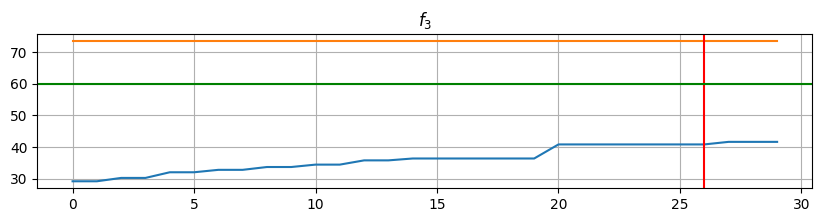

In [1197]:
req_len = len(previous_requests)
prev_idx = 26

f1_lb, f1_ub = np.array([]), np.array([])
f2_lb, f2_ub = np.array([]), np.array([])
f3_lb, f3_ub = np.array([]), np.array([])

for prev_req_data in previous_requests:
    f1_lb, f1_ub = np.append(f1_lb, prev_req_data.content["reachable_lb"][0]), np.append(f1_ub, prev_req_data.content["reachable_ub"][0])
    f2_lb, f2_ub = np.append(f2_lb, prev_req_data.content["reachable_lb"][1]), np.append(f2_ub, prev_req_data.content["reachable_ub"][1])
    f3_lb, f3_ub = np.append(f3_lb, prev_req_data.content["reachable_lb"][2]), np.append(f3_ub, prev_req_data.content["reachable_ub"][2])

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_1$')
plt.plot(np.linspace(0, req_len - 1, req_len), f1_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f1_ub)
plt.axvline(prev_idx, c='r')
plt.axhline(reference_point[0], c='g')
plt.savefig('plot/nautilus/f1_1.png')

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_2$')
plt.plot(np.linspace(0, req_len - 1, req_len), f2_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f2_ub)
plt.axvline(prev_idx, c='r')
plt.axhline(reference_point[1], c='g')
plt.savefig('plot/nautilus/f2_1.png')

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_3$')
plt.plot(np.linspace(0, req_len - 1, req_len), f3_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f3_ub)
plt.axvline(prev_idx, c='r')
plt.axhline(reference_point[2], c='g')
plt.savefig('plot/nautilus/f3_1.png')

In [1198]:
req_prev = previous_requests[prev_idx]
print(req_prev.content["reachable_lb"])
print(req_prev.content["reachable_ub"])
print(req_prev.content["step_number"])

[24.64287491  6.         40.83100625]
[ 89.80123534 118.          73.48069231]
27


In [1199]:
new_ref_point = np.array([60, 65, 68])
req_prev.response["go_to_previous"] = True
req_prev.response["reference_point"] = new_ref_point
new_response = req_prev.response

In [1200]:
req_prev = method.iterate(req_prev)
req = req_prev

previous_requests = [req_first, req_prev]

new_response["go_to_previous"] = False

while method._step_number < 100:
    req.response = new_response
    req = method.iterate(req)

    previous_requests.append(req)

print(req.content["reachable_idx"])

565


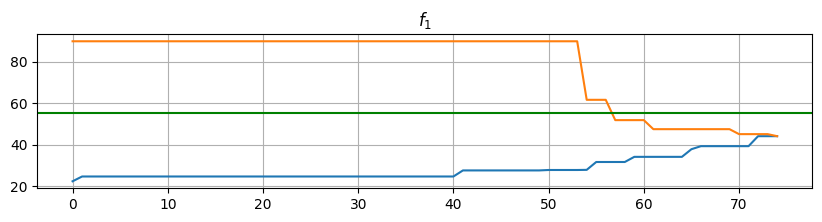

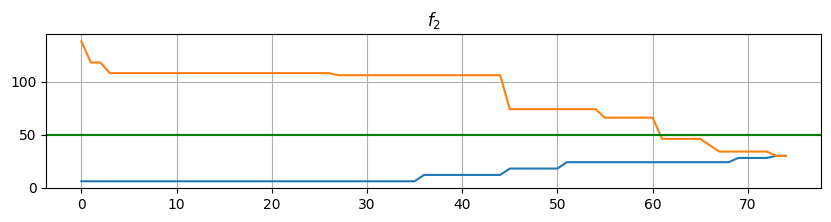

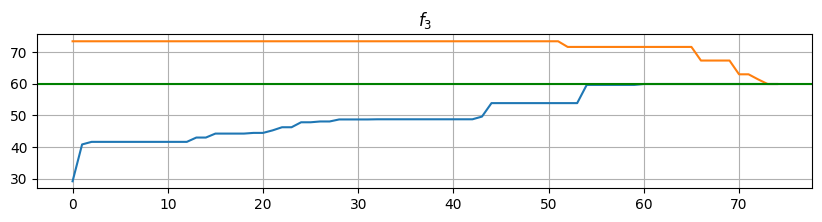

In [1201]:
req_len = len(previous_requests)

f1_lb, f1_ub = np.array([]), np.array([])
f2_lb, f2_ub = np.array([]), np.array([])
f3_lb, f3_ub = np.array([]), np.array([])

for prev_req_data in previous_requests:
    f1_lb, f1_ub = np.append(f1_lb, prev_req_data.content["reachable_lb"][0]), np.append(f1_ub, prev_req_data.content["reachable_ub"][0])
    f2_lb, f2_ub = np.append(f2_lb, prev_req_data.content["reachable_lb"][1]), np.append(f2_ub, prev_req_data.content["reachable_ub"][1])
    f3_lb, f3_ub = np.append(f3_lb, prev_req_data.content["reachable_lb"][2]), np.append(f3_ub, prev_req_data.content["reachable_ub"][2])

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_1$')
plt.plot(np.linspace(0, req_len - 1, req_len), f1_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f1_ub)
plt.axhline(reference_point[0], c='g')
plt.savefig('plot/nautilus/f1_2.png')

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_2$')
plt.plot(np.linspace(0, req_len - 1, req_len), f2_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f2_ub)
plt.axhline(reference_point[1], c='g')
plt.savefig('plot/nautilus/f2_2.png')

plt.figure(figsize=(10, 2))
plt.grid()
plt.title('$f_3$')
plt.plot(np.linspace(0, req_len - 1, req_len), f3_lb)
plt.plot(np.linspace(0, req_len - 1, req_len), f3_ub)
plt.axhline(reference_point[2], c='g')
plt.savefig('plot/nautilus/f3_2.png')


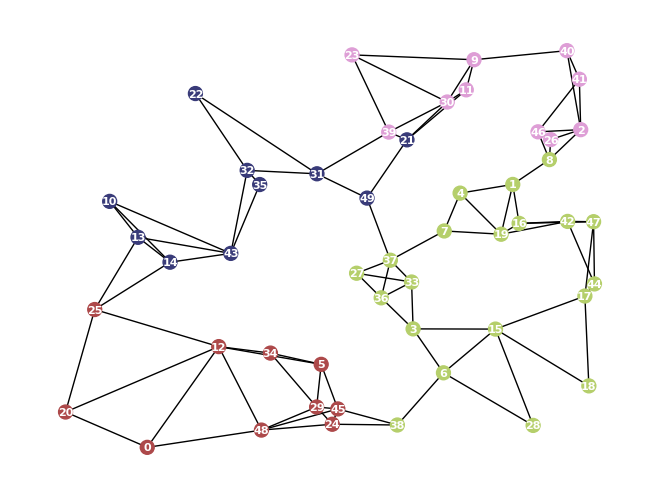

In [1202]:
if(req.content['reachable_idx'].shape != ()):
    for i in req.content["reachable_idx"]:
        partition_result = populations[i].get_partition()
        node_colors = [partition_result[node] for node in G.nodes()]
        labels = {node: f'{node}' for node in G.nodes()}
        label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

        plt.figure()
        nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
        nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

        plt.show()
else: 
    partition_result = populations[req.content["reachable_idx"]].get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()

In [1203]:
populations[req.content["reachable_idx"]].get_partition()

array([3., 2., 4., 2., 2., 3., 2., 2., 2., 4., 1., 4., 3., 1., 1., 2., 2.,
       2., 2., 2., 3., 1., 1., 4., 3., 3., 4., 2., 2., 3., 4., 1., 1., 2.,
       3., 1., 2., 2., 2., 4., 4., 4., 2., 1., 2., 3., 4., 2., 3., 1.])

In [1204]:
output.loc[req.content["reachable_idx"]]

index     565.000000
f1         44.068927
f2         30.000000
f3         59.956381
var         3.000000
var.1       2.000000
var.2       4.000000
var.3       2.000000
var.4       2.000000
var.5       3.000000
var.6       2.000000
var.7       2.000000
var.8       2.000000
var.9       4.000000
var.10      1.000000
var.11      4.000000
var.12      3.000000
var.13      1.000000
var.14      1.000000
var.15      2.000000
var.16      2.000000
var.17      2.000000
var.18      2.000000
var.19      2.000000
var.20      3.000000
var.21      1.000000
var.22      1.000000
var.23      4.000000
var.24      3.000000
var.25      3.000000
var.26      4.000000
var.27      2.000000
var.28      2.000000
var.29      3.000000
var.30      4.000000
var.31      1.000000
var.32      1.000000
var.33      2.000000
var.34      3.000000
var.35      1.000000
var.36      2.000000
var.37      2.000000
var.38      2.000000
var.39      4.000000
var.40      4.000000
var.41      4.000000
var.42      2.000000
var.43      1